In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cv2

In [138]:
test_image = cv2.imread('DataBase/Messenger/Messenger_1.png',-1)

#test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY) ## Problème car fond transparent
test_image=255-test_image
test_image = cv2.resize(test_image, (8, 8))


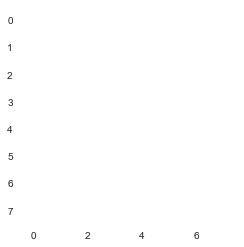

In [139]:
plt.imshow(test_image)

In [109]:
test_image

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255